###**ATOC4500 Data Science Lab: Final Project**
###**Analyzing Seasonality of Temperature & Pressure Data in Denver and Boston from 2012 to 2021 Using K-Clustering Techniques**
###Author: Gillian Grasso & Jackie Katsirubas###
###gigr9212@colorado.edu
###jaka0184@colorado.edu
###last updated: April 27, 2022###

**>>>> This code is available on github at https://github.com/jkatsirubas/ATOC4500_KatsirubasGrasso_FinalProject**

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

##**Introduction**


The goal of this project is to analyze the seasonality between Boston and Denver for the years 2012-2021. This will be done by using k-means clustering on various weather variables from the datasets. K clustering provides a relatively simple grouping technique by creating k (in our case, 4) clusters where the data points “belong” to the cluster with the nearest center. The ideal distribution of clusters minimizes the distance between each center and the data points that belong to each cluster; this is known as minimizing the within cluster sum of squares (Barnes/Kay). By creating four season-based clusters for the Boston and Denver data sets, we will be able to estimate which city demonstrates more seasonality for the chosen weather variables. We hypothesize that under four seasonal clusters, the Boston weather variables will produce more statistically distinct clusters than Denver. This is based on anecdotal evidence from friends that have lived in both places; according to them, the northeast typically demonstrates more obvious seasonality than Colorado.

The eight atmospheric variables included within the LCD datasets for Boston (“Local Climatological Data (LCD) Boston Dataset 2012-2021”) and Denver (“Local Climatological Data (LCD) Denver Dataset 2002-2021”) are as follows: dry bulb temperature (in degrees Fahrenheit), dewpoint temperature (in degrees fahrenheit), precipitation (in inches), relative humidity, pressure (in millibars), wind direction (in degrees), wind speed (in miles per hour), and wind gust (in miles per hour). The Boston data spans from January of 2012 to December of 2021, while the Denver data spans from January of 2002 to December of 2021. Values are recorded approximately every hour for the Boston data and every 20 minutes for the Denver data, although the time data is taken at the Denver site varies considerably from year to year (this causes problems for us later in the analysis). Munging techniques have been applied to the original datasets; munging is implemented by determining which columns will be included, converting the ‘DATE’ column to a datetime object, reordering variables within the dataframe, as well as through the removal of blank (NaN values). Missing values were removed by utilizing a function within Python that recognizes these values and excludes them from a new dataframe containing no missing values.

Some limitations of the datasets are that comparison will be difficult due to the different years and data sampling times between each dataset. We will use code to select only the years we need from the Denver dataset to match the Boston dataset, but the difference in sampling times is a more difficult problem. The sampling time for Denver changes significantly from year to year, making it much more difficult to isolate a time to sample for each day. This created a lot of problems for our analysis, which will be addressed throughout the notebook.

###**Step 1: Read in data**



In this section, we read in the data and preview the head and tail of the datasets to make sure everything looks okay. We also created some quick plots to represent time series for the weather variables for both the Boston and Denver locations.

In [ ]:
import pandas as pd
import numpy as np
import datetime
#import datetime as dt
from google.colab import files

from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [ ]:
## upload hourly Boston data
boston_uploaded = files.upload()

for fn in boston_uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(boston_uploaded[fn])))#

Saving 72509014739_BOS_2012-2021_hourlydata_munged.csv to 72509014739_BOS_2012-2021_hourlydata_munged.csv
User uploaded file "72509014739_BOS_2012-2021_hourlydata_munged.csv" with length 11868198 bytes


In [ ]:
## upload hourly Denver data
denver_uploaded = files.upload()

for fn in denver_uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(denver_uploaded[fn])))#

Saving 72565003017_DEN_2002-2021_hourlydata_munged.csv to 72565003017_DEN_2002-2021_hourlydata_munged.csv
User uploaded file "72565003017_DEN_2002-2021_hourlydata_munged.csv" with length 33031172 bytes


In [ ]:
## read in munged Boston data 
bos_df = pd.read_csv("72509014739_BOS_2012-2021_hourlydata_munged.csv")

## specify which columns should remain in dataset
included_bos_cols = ['drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph']

## initialize a numpy array of Boston data
bos_data = bos_df.loc[:, bos_df.columns.isin(list(included_bos_cols))].to_numpy()

bos_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2012-01-01T00:54:00,2012-01-01 00:54:00,40.0,35.0,0.0,83.0,1011.85297,310.0,9.0,23.0
1,2012-01-01T01:00:00,2012-01-01 01:00:00,40.0,35.0,0.0,83.0,1012.19160,310.0,9.0,23.0
2,2012-01-01T01:54:00,2012-01-01 01:54:00,40.0,35.0,0.0,83.0,1012.86890,280.0,9.0,23.0
3,2012-01-01T02:54:00,2012-01-01 02:54:00,41.0,36.0,0.0,82.0,1013.54614,270.0,9.0,23.0
4,2012-01-01T03:54:00,2012-01-01 03:54:00,42.0,36.0,0.0,79.0,1014.22345,290.0,10.0,23.0
...,...,...,...,...,...,...,...,...,...,...
140234,2021-12-31T22:00:00,2021-12-31 22:00:00,44.0,43.0,0.0,96.0,1013.54614,170.0,3.0,20.0
140235,2021-12-31T22:54:00,2021-12-31 22:54:00,45.0,43.0,0.0,93.0,1013.54614,190.0,3.0,20.0
140236,2021-12-31T23:54:00,2021-12-31 23:54:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0
140237,2021-12-31T23:59:00,2021-12-31 23:59:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0


In [ ]:
## read in munged Denver data 
den_df = pd.read_csv("72565003017_DEN_2002-2021_hourlydata_munged.csv")

## specify which columns should remain in dataset
included_den_cols = ['drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph']

## initialize a numpy array of Denver data
den_data = den_df.loc[:, den_df.columns.isin(list(included_den_cols))].to_numpy()

den_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2002-01-01T00:36:00,2002-01-01 00:36:00,19.0,18.0,0.00,93.0,839.14716,60.0,9.0,26.0
1,2002-01-01T00:45:00,2002-01-01 00:45:00,19.0,19.0,0.00,100.0,839.14716,60.0,10.0,26.0
2,2002-01-01T00:53:00,2002-01-01 00:53:00,19.0,17.0,0.00,92.0,839.14716,70.0,9.0,26.0
3,2002-01-01T01:20:00,2002-01-01 01:20:00,18.0,18.0,0.00,100.0,839.14716,60.0,8.0,26.0
4,2002-01-01T01:44:00,2002-01-01 01:44:00,18.0,18.0,0.00,100.0,839.14716,60.0,6.0,26.0
...,...,...,...,...,...,...,...,...,...,...
394739,2021-12-31T22:55:00,2021-12-31 22:55:00,16.0,14.0,0.02,93.0,827.29480,40.0,3.0,18.0
394740,2021-12-31T23:15:00,2021-12-31 23:15:00,16.0,14.0,0.02,93.0,827.29480,30.0,5.0,18.0
394741,2021-12-31T23:35:00,2021-12-31 23:35:00,16.0,14.0,0.02,93.0,827.29480,30.0,6.0,18.0
394742,2021-12-31T23:55:00,2021-12-31 23:55:00,14.0,12.0,0.02,92.0,827.29480,20.0,6.0,18.0


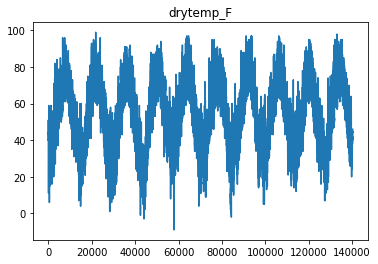

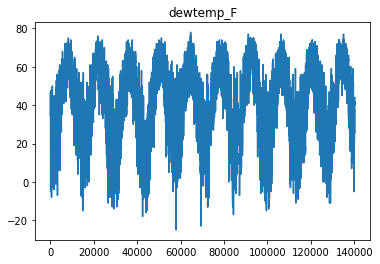

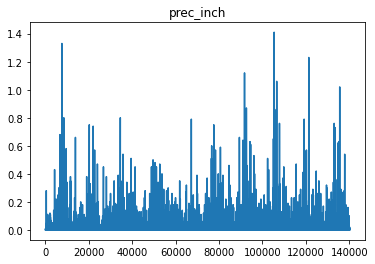

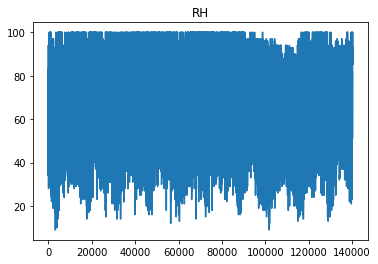

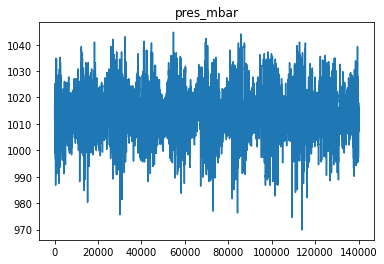

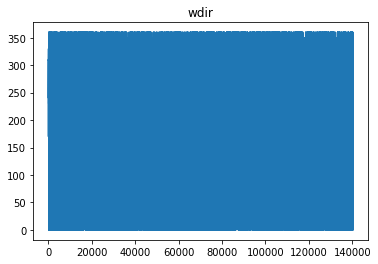

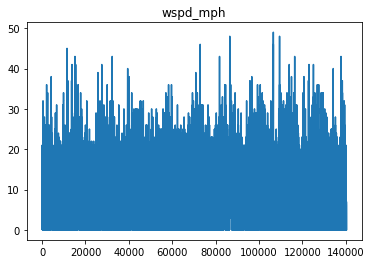

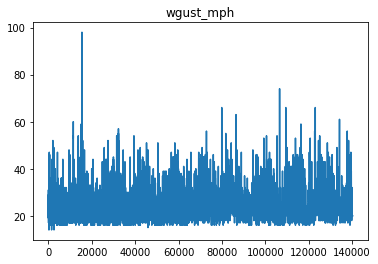

In [ ]:
## quick plots of Boston data
for i in np.arange(0,np.shape(bos_data)[1]):
  plt.plot(bos_data[:,i]);
  plt.title(included_bos_cols[i])
  plt.show()

del bos_data

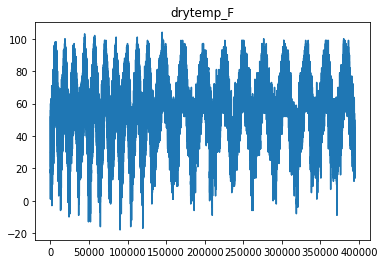

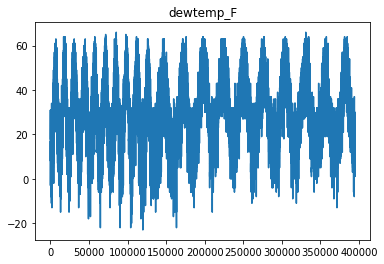

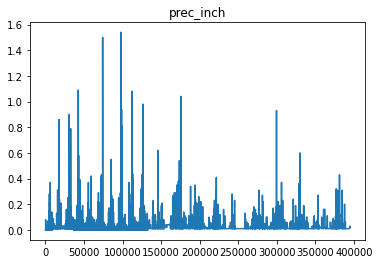

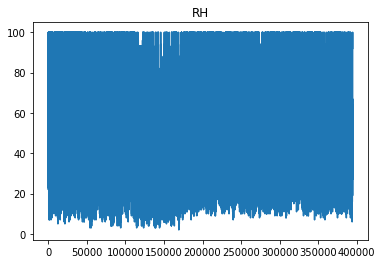

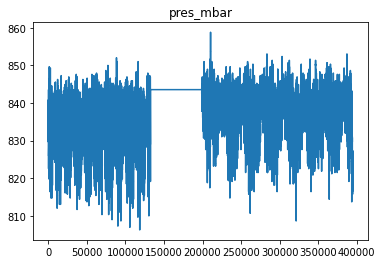

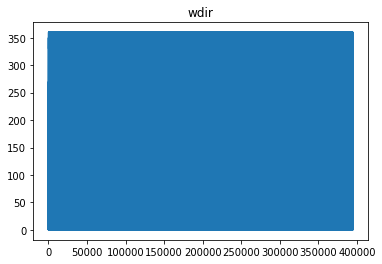

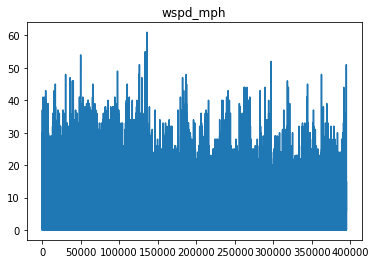

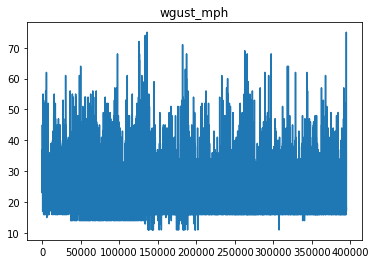

In [ ]:
## quick plots of Denver data
for i in np.arange(0,np.shape(den_data)[1]):
  plt.plot(den_data[:,i]);
  plt.title(included_den_cols[i])
  plt.show()

del den_data

As one can see from the plots, the included times within the dataset produce awkward plots with very little discernibility between values. Therefore, these data will need to be further adjusted to isolate a specific time of day (in particular, approximately 0600 UTC) in order to produce more meaningful visuals.

###**Step 2: Munge data**

To make our data easier to work with, we used datetime to create columns with only the date and time in case we need to reference these later. We also filtered the Denver dataset to only include data from the years 2012-2021 to coincide with the Boston data. We then isolated a time of 5:54 AM for the Boston data and 5:56 AM for the Denver data.

In [ ]:
## code using pandas built-in list comprehension to create 'Date Only' and 'Time' columns in Boston dataframe
bos_df['datetime'] = pd.to_datetime(bos_df['datetime'])

bos_df['Date Only'] = bos_df['datetime'].dt.date
bos_df['Time']      = bos_df['datetime'].dt.time

bos_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,Date Only,Time
0,2012-01-01T00:54:00,2012-01-01 00:54:00,40.0,35.0,0.0,83.0,1011.85297,310.0,9.0,23.0,2012-01-01,00:54:00
1,2012-01-01T01:00:00,2012-01-01 01:00:00,40.0,35.0,0.0,83.0,1012.19160,310.0,9.0,23.0,2012-01-01,01:00:00
2,2012-01-01T01:54:00,2012-01-01 01:54:00,40.0,35.0,0.0,83.0,1012.86890,280.0,9.0,23.0,2012-01-01,01:54:00
3,2012-01-01T02:54:00,2012-01-01 02:54:00,41.0,36.0,0.0,82.0,1013.54614,270.0,9.0,23.0,2012-01-01,02:54:00
4,2012-01-01T03:54:00,2012-01-01 03:54:00,42.0,36.0,0.0,79.0,1014.22345,290.0,10.0,23.0,2012-01-01,03:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...
140234,2021-12-31T22:00:00,2021-12-31 22:00:00,44.0,43.0,0.0,96.0,1013.54614,170.0,3.0,20.0,2021-12-31,22:00:00
140235,2021-12-31T22:54:00,2021-12-31 22:54:00,45.0,43.0,0.0,93.0,1013.54614,190.0,3.0,20.0,2021-12-31,22:54:00
140236,2021-12-31T23:54:00,2021-12-31 23:54:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0,2021-12-31,23:54:00
140237,2021-12-31T23:59:00,2021-12-31 23:59:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0,2021-12-31,23:59:00


In [ ]:
## code using pandas built-in list comprehension to create 'Date Only' and 'Time' columns in Denver dataframe 
den_df['datetime'] = pd.to_datetime(den_df['datetime'])

den_df['Date Only'] = den_df['datetime'].dt.date
den_df['Time']      = den_df['datetime'].dt.time

den_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,Date Only,Time
0,2002-01-01T00:36:00,2002-01-01 00:36:00,19.0,18.0,0.00,93.0,839.14716,60.0,9.0,26.0,2002-01-01,00:36:00
1,2002-01-01T00:45:00,2002-01-01 00:45:00,19.0,19.0,0.00,100.0,839.14716,60.0,10.0,26.0,2002-01-01,00:45:00
2,2002-01-01T00:53:00,2002-01-01 00:53:00,19.0,17.0,0.00,92.0,839.14716,70.0,9.0,26.0,2002-01-01,00:53:00
3,2002-01-01T01:20:00,2002-01-01 01:20:00,18.0,18.0,0.00,100.0,839.14716,60.0,8.0,26.0,2002-01-01,01:20:00
4,2002-01-01T01:44:00,2002-01-01 01:44:00,18.0,18.0,0.00,100.0,839.14716,60.0,6.0,26.0,2002-01-01,01:44:00
...,...,...,...,...,...,...,...,...,...,...,...,...
394739,2021-12-31T22:55:00,2021-12-31 22:55:00,16.0,14.0,0.02,93.0,827.29480,40.0,3.0,18.0,2021-12-31,22:55:00
394740,2021-12-31T23:15:00,2021-12-31 23:15:00,16.0,14.0,0.02,93.0,827.29480,30.0,5.0,18.0,2021-12-31,23:15:00
394741,2021-12-31T23:35:00,2021-12-31 23:35:00,16.0,14.0,0.02,93.0,827.29480,30.0,6.0,18.0,2021-12-31,23:35:00
394742,2021-12-31T23:55:00,2021-12-31 23:55:00,14.0,12.0,0.02,92.0,827.29480,20.0,6.0,18.0,2021-12-31,23:55:00


In [ ]:
## specify columns that should be included from Denver dataset
cols     = ['DATE', 'datetime', 'drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph', 'Date Only', 'Time']
den_list = []

ref_date = pd.to_datetime('2011-12-31').date()

## iterating over data in Denver dataframe to only add data from specified years 
for index, row in den_df.iterrows():
    if den_df.iloc[index,10] >= ref_date:
        den_list.append(row)

## initialize a new dataframe of Denver data for only years 2012-2021
filtered_den_df = pd.DataFrame(den_list, columns=cols).reset_index(drop=True)

## delete this object to save memory
del den_list

filtered_den_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,Date Only,Time
0,2011-12-31T00:53:00,2011-12-31 00:53:00,44.0,19.0,0.00,37.0,822.5539,190.0,18.0,23.0,2011-12-31,00:53:00
1,2011-12-31T01:53:00,2011-12-31 01:53:00,45.0,19.0,0.00,35.0,821.5379,180.0,17.0,25.0,2011-12-31,01:53:00
2,2011-12-31T02:00:00,2011-12-31 02:00:00,45.0,19.0,0.00,35.0,823.2311,180.0,17.0,25.0,2011-12-31,02:00:00
3,2011-12-31T02:53:00,2011-12-31 02:53:00,44.0,20.0,0.00,38.0,821.1993,190.0,20.0,25.0,2011-12-31,02:53:00
4,2011-12-31T03:53:00,2011-12-31 03:53:00,44.0,19.0,0.00,37.0,820.5220,210.0,17.0,25.0,2011-12-31,03:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...
262236,2021-12-31T22:55:00,2021-12-31 22:55:00,16.0,14.0,0.02,93.0,827.2948,40.0,3.0,18.0,2021-12-31,22:55:00
262237,2021-12-31T23:15:00,2021-12-31 23:15:00,16.0,14.0,0.02,93.0,827.2948,30.0,5.0,18.0,2021-12-31,23:15:00
262238,2021-12-31T23:35:00,2021-12-31 23:35:00,16.0,14.0,0.02,93.0,827.2948,30.0,6.0,18.0,2021-12-31,23:35:00
262239,2021-12-31T23:55:00,2021-12-31 23:55:00,14.0,12.0,0.02,92.0,827.2948,20.0,6.0,18.0,2021-12-31,23:55:00


In [ ]:
## create an array that tells me if the row is after 2011 or not
after2011 = den_df['Date Only'] > ref_date

## Select only the days after 2011 using after2011
den_df_after2011 = den_df[after2011]

## Select only the variables that you're interested in
den_df_after2011_varsubset = den_df_after2011[cols]

## reset your index so the new data starts at 1!
filtered_den_df2 = den_df_after2011_varsubset.reset_index()

## clean up intermediate variables to save on memory
del den_df_after2011,den_df_after2011_varsubset

In [ ]:
## create a new dataframe of Boston data containing only the specified columns
filtered_bos_df = bos_df[cols]

filtered_bos_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,Date Only,Time
0,2012-01-01T00:54:00,2012-01-01 00:54:00,40.0,35.0,0.0,83.0,1011.85297,310.0,9.0,23.0,2012-01-01,00:54:00
1,2012-01-01T01:00:00,2012-01-01 01:00:00,40.0,35.0,0.0,83.0,1012.19160,310.0,9.0,23.0,2012-01-01,01:00:00
2,2012-01-01T01:54:00,2012-01-01 01:54:00,40.0,35.0,0.0,83.0,1012.86890,280.0,9.0,23.0,2012-01-01,01:54:00
3,2012-01-01T02:54:00,2012-01-01 02:54:00,41.0,36.0,0.0,82.0,1013.54614,270.0,9.0,23.0,2012-01-01,02:54:00
4,2012-01-01T03:54:00,2012-01-01 03:54:00,42.0,36.0,0.0,79.0,1014.22345,290.0,10.0,23.0,2012-01-01,03:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...
140234,2021-12-31T22:00:00,2021-12-31 22:00:00,44.0,43.0,0.0,96.0,1013.54614,170.0,3.0,20.0,2021-12-31,22:00:00
140235,2021-12-31T22:54:00,2021-12-31 22:54:00,45.0,43.0,0.0,93.0,1013.54614,190.0,3.0,20.0,2021-12-31,22:54:00
140236,2021-12-31T23:54:00,2021-12-31 23:54:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0,2021-12-31,23:54:00
140237,2021-12-31T23:59:00,2021-12-31 23:59:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0,2021-12-31,23:59:00


In [ ]:
## specify columns that should be included from each dataset
cols          = ['DATE', 'datetime', 'drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph', 'Date Only', 'Time']
included_cols = ['drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph']

## initialize lists that will hold data from both cities for only the specified times 
bos_list = []
den_list = []

morning_bos_data = []
morning_den_data = []

## specify which times within the dataset should be used
bos_time = pd.to_datetime('05:54:00').time()
den_time = pd.to_datetime('05:56:00').time()


## select observations at the same time of the day to shrink the data
for index, row in filtered_bos_df.iterrows():
# indexing by the column name
  if row['Time'] == bos_time: 
      bos_list.append(row)

# create a new dataframe from the morning Boston data
morning_bos_df = pd.DataFrame(bos_list, columns=cols).reset_index(drop=True)
del bos_list

# repeat selecting morning data from Denver
for index, row in filtered_den_df.iterrows():  
# indexing by the column name
  if row['Time'] == den_time: 
      den_list.append(row)

morning_den_df = pd.DataFrame(den_list, columns=cols).reset_index(drop=True)
del den_list

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
morning_bos_data = morning_bos_df.loc[:, morning_bos_df.columns.isin(list(included_cols))].to_numpy()

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
morning_den_data = morning_den_df.loc[:, morning_den_df.columns.isin(list(included_cols))].to_numpy()

We now have much more filtered data to work with; the years for both datasets match up, and there is a similar time selected for each one. The only problem going forwards is that 5:54 AM is not an entirely consistent time for the Denver dataset; because sampling differs so much in consistency, it’s difficult to say if every year we want will be included.

###**Step 3: Apply Data Science Method(s)**

This step is where we prep our data for k-means clustering. First we define seasons so our clusters will be month-based. Then we make quick plots of all the data to get a preliminary visual of what we have generated. Finally, we rescale both datasets using the whiten function.

In [ ]:
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
## define a function to assign seasons to months using the dictionary
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

## apply the function season to all times in my dataset
morning_bos_df['season']=[season(month) for month in pd.DatetimeIndex(morning_bos_df['Date Only']).month]
morning_den_df['season']=[season(month) for month in pd.DatetimeIndex(morning_den_df['Date Only']).month]

print(morning_bos_df)
print(morning_den_df)

                     DATE            datetime  drytemp_F  dewtemp_F  \
0     2012-01-01T05:54:00 2012-01-01 05:54:00       40.0       35.0   
1     2012-01-02T05:54:00 2012-01-02 05:54:00       42.0       31.0   
2     2012-01-03T05:54:00 2012-01-03 05:54:00       29.0       13.0   
3     2012-01-04T05:54:00 2012-01-04 05:54:00       11.0       -3.0   
4     2012-01-05T05:54:00 2012-01-05 05:54:00       26.0        9.0   
...                   ...                 ...        ...        ...   
3648  2021-12-27T05:54:00 2021-12-27 05:54:00       31.0       22.0   
3649  2021-12-28T05:54:00 2021-12-28 05:54:00       35.0       34.0   
3650  2021-12-29T05:54:00 2021-12-29 05:54:00       37.0       33.0   
3651  2021-12-30T05:54:00 2021-12-30 05:54:00       40.0       33.0   
3652  2021-12-31T05:54:00 2021-12-31 05:54:00       41.0       40.0   

      prec_inch    RH   pres_mbar   wdir  wspd_mph  wgust_mph   Date Only  \
0          0.00  83.0  1015.23930  270.0       8.0       23.0  2012-01

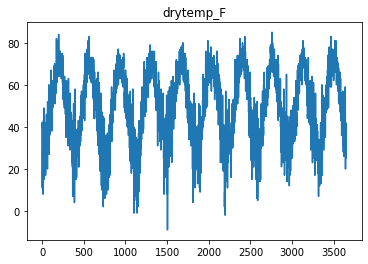

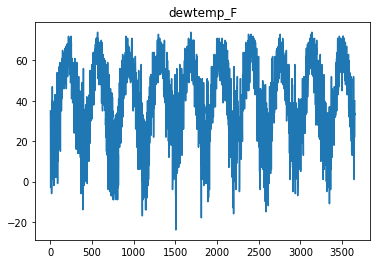

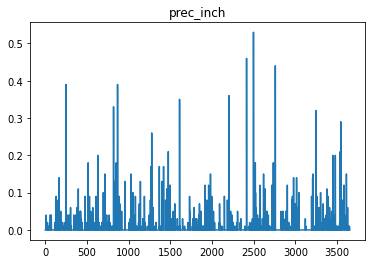

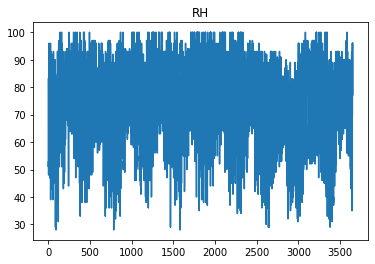

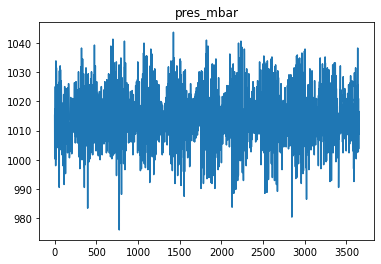

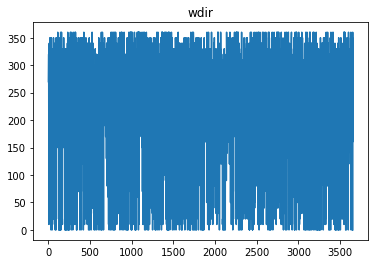

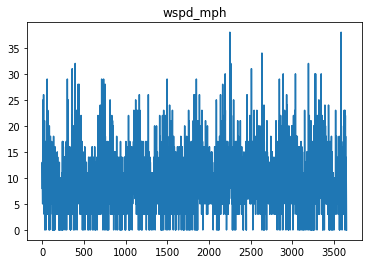

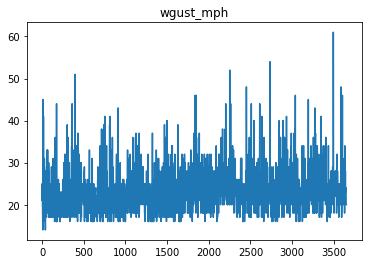

In [ ]:
## quick plots of Boston data
for i in np.arange(0,np.shape(morning_bos_data)[1]):
  plt.plot(morning_bos_data[:,i])
  plt.title(included_bos_cols[i])
  plt.show()

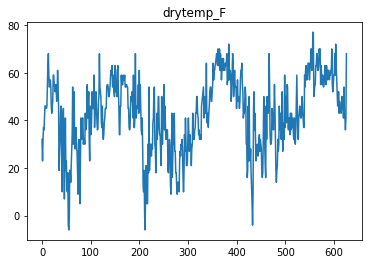

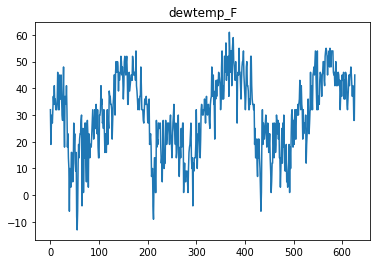

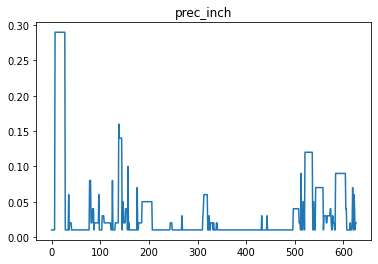

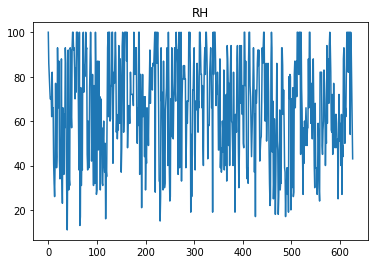

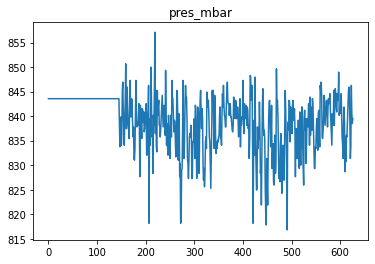

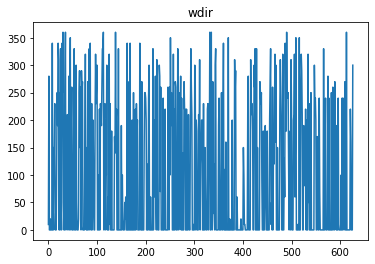

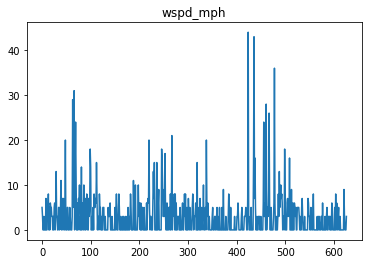

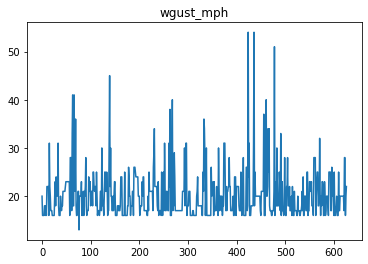

In [ ]:
## quick plots of Denver data
for i in np.arange(0,np.shape(morning_den_data)[1]):
  plt.plot(morning_den_data[:,i]);
  plt.title(included_den_cols[i])
  plt.show()

In [ ]:
## rescale both datasets using whiten function
scaled_bos_data = whiten(morning_bos_data)

scaled_den_data = whiten(morning_den_data)

Now we have our seasons defined, have performed a visual data check, the data has been rescaled, and we’re ready to move on to actually k-means clustering.

###**Step 4.1: Present results visually using 2-3 graphs**

In ths section we start by making some quickplots, followed by plotting the clustering indices for each day of the year for each city. Then we make some (x,y) scatterplots of the clusters using the temperature and pressure data for Boston and Denver respectively.

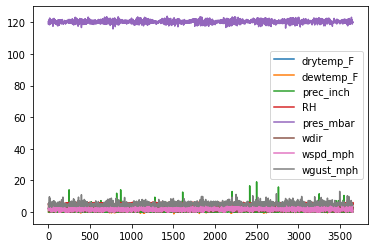

In [ ]:
## quick plots of Boston data
for i in np.arange(0,np.shape(scaled_bos_data)[1]):
  plt.plot(scaled_bos_data[:,i],label=included_bos_cols[i]);
  plt.legend()

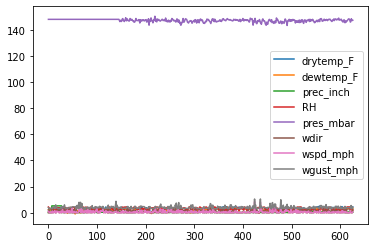

In [ ]:
## quick plots of Denver data
for i in np.arange(0,np.shape(scaled_den_data)[1]):
  plt.plot(scaled_den_data[:,i],label=included_den_cols[i]);
  plt.legend()

Print the cluster idx for each day of the year:
[3 4 1 ... 2 3 2]


Text(0.5, 0, 'Days within Dataset')

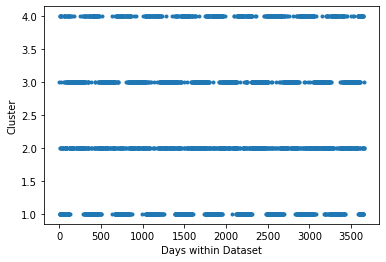

In [ ]:
## specify the number of clusters used to distribute Boston data
num_bos_clusters = 4

## identify the centroids for morning Boston datasaet, or the coordinats of the cluster centers
bos_centroids, _  = kmeans(scaled_bos_data, num_bos_clusters,iter=20)

## find an index that is the label for each value in morning Boston dataset
bos_idx, _ = vq(scaled_bos_data, bos_centroids)

## add 1 so that idx is also 1-based like morning_bos_df['season']
bos_idx=bos_idx+1

print('Print the cluster idx for each day of the year:') 
print(bos_idx) # prints K-mean's season label for each day in the year

day = np.arange(1,3654,1)
plt.plot(day, bos_idx,'.')
plt.ylabel('Cluster')
plt.xlabel('Days within Dataset')

Print the cluster idx for each day of the year:
[4 4 4 4 4 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 1 4 4
 4 1 1 4 4 1 4 1 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1 1 4 1 1 1 4 4 4
 4 4 4 4 4 4 3 1 4 1 1 4 1 4 4 1 4 4 1 3 3 3 1 4 4 1 1 4 3 3 3 1 3 1 4 1 1
 1 1 1 4 1 1 3 1 1 1 3 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 3 2 3 3 3
 3 3 1 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 1 1 3
 3 3 3 1 4 3 3 1 3 3 3 3 3 1 3 1 1 3 3 4 4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4
 4 4 4 4 4 4 1 1 1 1 4 4 4 4 1 4 4 1 1 4 4 4 4 4 1 4 4 1 1 1 1 1 4 4 4 1 4
 4 4 1 1 4 4 4 4 1 4 4 1 4 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1
 4 4 4 4 4 1 1 4 4 4 4 4 4 4 1 4 4 4 4 4 1 3 3 1 3 3 4 4 4 4 4 4 1 3 3 3 1
 3 3 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3
 3 3 3 1 1 3 3 3 3 3 3 1 1 4 4 4 4 1 4 1 4 4 4 4 4 4 4 4 1 1 1 1 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 1 1 1 4 4 4 1 4 1 1 1 1 1 1 4

Text(0.5, 0, 'Days within Dataset')

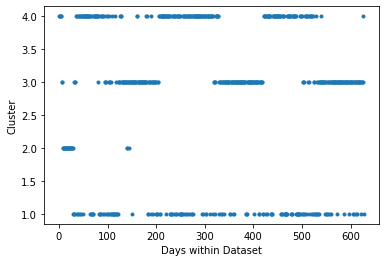

In [ ]:
## specify the number of clusters used to distribute Denver data
num_den_clusters = 4

## identify the centroids for morning Denver datasaet, or the coordinats of the cluster centers
den_centroids, _  = kmeans(scaled_den_data, num_den_clusters,iter=20)

## find an index that is the label for each value in morning Denver dataset
den_idx, _ = vq(scaled_den_data, den_centroids)

## add 1 so that idx is also 1-based like morning_den_df['season']
den_idx=den_idx+1

print('Print the cluster idx for each day of the year:') 
print(den_idx) # prints K-mean's season label for each day in the year

day = np.arange(1,628,1)
plt.plot(day, den_idx, '.')
plt.ylabel('Cluster')
plt.xlabel('Days within Dataset')

['drytemp_F', 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph', 'wgust_mph']
plotting these variables: ['drytemp_F', 'pres_mbar']
drytemp_F
pres_mbar


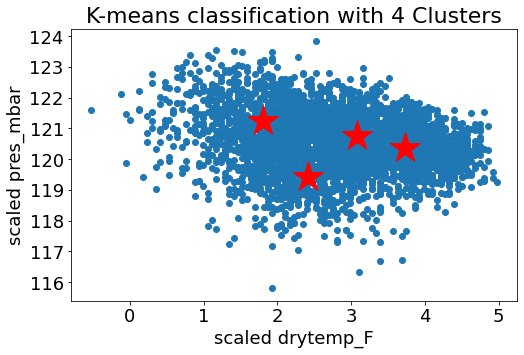

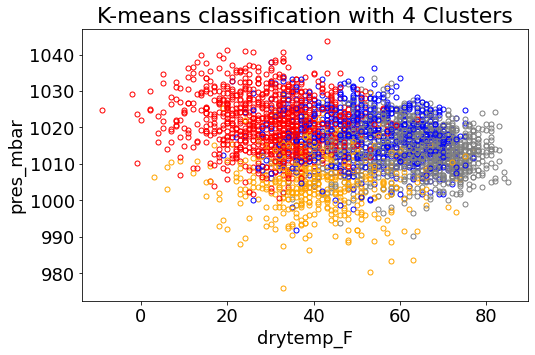

In [ ]:
## create a few xy scatter plots, where points are colored by "season" and each k-means-determined centroid is in a red stars overlaid.

## pick any two variables that are a part of included_cols
print(included_bos_cols)
## select two variables and put them in vars2plot - # format (x, y)
#plotted_bos_vars = ['drytemp_F','wgust_mph']

## other options for variables to plot
#plotted_bos_vars = ['RH','wspd_mph']
plotted_bos_vars = ['drytemp_F','pres_mbar']
#plotted_bos_vars = ['drytemp_F','wspd_mph']
#plotted_bos_vars = ['wspd_mph','wgust_mph']

print(f'plotting these variables: {plotted_bos_vars}')

plotted_bos_data = [morning_bos_data[:,included_bos_cols.index(var)] for var in plotted_bos_vars]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  print(plotted_bos_vars[i])
  varidx2plot[i]=included_bos_cols.index(plotted_bos_vars[i])

## plot these variables as scaled values with the cluster centers
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_bos_clusters) + ' Clusters',fontsize=22)
plt.scatter(scaled_bos_data[:, varidx2plot[0]], scaled_bos_data[:, varidx2plot[1]])
plt.scatter(bos_centroids[:, varidx2plot[0]], bos_centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('scaled '+plotted_bos_vars[0],fontsize=18);
plt.ylabel('scaled '+plotted_bos_vars[1],fontsize=18);
plt.show()

## plot these variables as the original values with colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_bos_clusters) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(plotted_bos_data)):
    plt.plot(val[0],val[1],".", color=cols[bos_idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(plotted_bos_vars[0],fontsize=18);
plt.ylabel(plotted_bos_vars[1],fontsize=18);

['drytemp_F', 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph', 'wgust_mph']
plotting these variables: ['drytemp_F', 'pres_mbar']
drytemp_F
pres_mbar


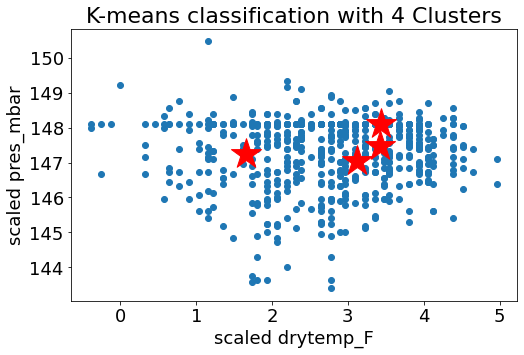

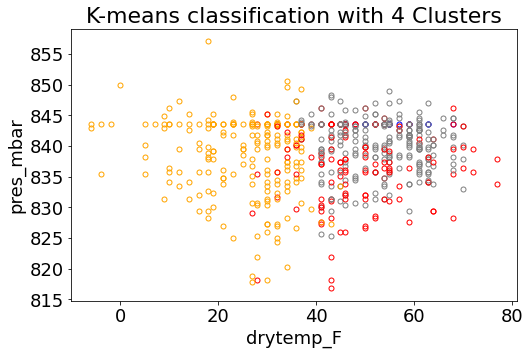

In [ ]:
## create a few xy scatter plots, where points are colored by "season" and each k-means-determined centroid is in a red stars overlaid.

## pick any two variables that are a part of included_cols
print(included_den_cols)
## select two variables and put them in vars2plot - # format (x, y)
#plotted_den_vars = ['drytemp_F','wgust_mph']

## other options for variables to plot
#plotted_den_vars = ['RH','wspd_mph']
plotted_den_vars = ['drytemp_F','pres_mbar']
#plotted_den_vars = ['drytemp_F','wspd_mph']
#plotted_den_vars = ['wspd_mph','wgust_mph']

print(f'plotting these variables: {plotted_den_vars}')

plotted_den_data = [morning_den_data[:,included_den_cols.index(var)] for var in plotted_den_vars]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  print(plotted_den_vars[i])
  varidx2plot[i]=included_den_cols.index(plotted_den_vars[i])

## plot these variables as scaled values with the cluster centers
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_den_clusters) + ' Clusters',fontsize=22)
plt.scatter(scaled_den_data[:, varidx2plot[0]], scaled_den_data[:, varidx2plot[1]])
plt.scatter(den_centroids[:, varidx2plot[0]], den_centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('scaled '+plotted_den_vars[0],fontsize=18);
plt.ylabel('scaled '+plotted_den_vars[1],fontsize=18);
plt.show()

## plot these variables as the original values with colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_den_clusters) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(plotted_den_data)):
    plt.plot(val[0],val[1],".", color=cols[den_idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(plotted_den_vars[0],fontsize=18);
plt.ylabel(plotted_den_vars[1],fontsize=18);

In this section, we can see that Boston actually produces some (visually) nice/distinct four clusters for the years 2012-2021. However, comparison with Denver is a little tricky because the Denver data looks a little wonky. We suspect that this is due to the inconsistent sampling rate of the Denver data, so not as much data is getting pulled as we actually want for all the years theoretically being included.

###**Step 4.2: Produce Plots for Boston & Denver Data for Only 2021**

Because comparison was so tricky between the two cities for 2012-2021, we decided to conduct an additional analysis with just the year 2021. By selecting just one year, it’s much easier to isolate a time to use from the Denver dataset. In this section, we will follow the same steps as sections 2-3, but filtering both datasets to include only data from the year 2021.

In [ ]:
## specify columns that should be included from Denver dataset
cols         = ['DATE', 'datetime', 'drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph', 'Date Only', 'Time']
new_den_list = []

new_ref_date = pd.to_datetime('2020-12-31').date()

## iterating over data in Denver dataframe to only add data from specified years 
for index, row in den_df.iterrows():
    if den_df.iloc[index,10] >= new_ref_date:
        new_den_list.append(row)

## initialize a new dataframe of Denver data for only years 2012-2021
xtra_filtered_den_df = pd.DataFrame(new_den_list, columns=cols).reset_index(drop=True)

## delete this object to save memory
del new_den_list

xtra_filtered_den_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,Date Only,Time
0,2020-12-31T00:15:00,2020-12-31 00:15:00,23.0,16.0,0.01,74.0,834.0675,0.0,0.0,29.0,2020-12-31,00:15:00
1,2020-12-31T00:35:00,2020-12-31 00:35:00,23.0,18.0,0.01,80.0,834.0675,0.0,0.0,29.0,2020-12-31,00:35:00
2,2020-12-31T00:55:00,2020-12-31 00:55:00,23.0,18.0,0.01,80.0,834.0675,0.0,0.0,29.0,2020-12-31,00:55:00
3,2020-12-31T01:15:00,2020-12-31 01:15:00,23.0,18.0,0.01,80.0,834.0675,0.0,0.0,29.0,2020-12-31,01:15:00
4,2020-12-31T01:35:00,2020-12-31 01:35:00,23.0,16.0,0.01,74.0,834.0675,0.0,0.0,29.0,2020-12-31,01:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...
26470,2021-12-31T22:55:00,2021-12-31 22:55:00,16.0,14.0,0.02,93.0,827.2948,40.0,3.0,18.0,2021-12-31,22:55:00
26471,2021-12-31T23:15:00,2021-12-31 23:15:00,16.0,14.0,0.02,93.0,827.2948,30.0,5.0,18.0,2021-12-31,23:15:00
26472,2021-12-31T23:35:00,2021-12-31 23:35:00,16.0,14.0,0.02,93.0,827.2948,30.0,6.0,18.0,2021-12-31,23:35:00
26473,2021-12-31T23:55:00,2021-12-31 23:55:00,14.0,12.0,0.02,92.0,827.2948,20.0,6.0,18.0,2021-12-31,23:55:00


In [ ]:
## specify columns that should be included from Denver dataset
cols         = ['DATE', 'datetime', 'drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph', 'Date Only', 'Time']
new_bos_list = []

## iterating over data in Denver dataframe to only add data from specified years 
for index, row in bos_df.iterrows():
    if bos_df.iloc[index,10] >= new_ref_date:
        new_bos_list.append(row)

## initialize a new dataframe of Denver data for only years 2012-2021
xtra_filtered_bos_df = pd.DataFrame(new_bos_list, columns=cols).reset_index(drop=True)

## delete this object to save memory
del new_bos_list

xtra_filtered_bos_df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,Date Only,Time
0,2020-12-31T00:54:00,2020-12-31 00:54:00,42.0,34.0,0.01,73.0,1014.22345,230.0,21.0,28.0,2020-12-31,00:54:00
1,2020-12-31T01:00:00,2020-12-31 01:00:00,42.0,34.0,0.01,73.0,1014.56210,230.0,21.0,31.0,2020-12-31,01:00:00
2,2020-12-31T01:54:00,2020-12-31 01:54:00,42.0,34.0,0.01,73.0,1013.20750,220.0,22.0,31.0,2020-12-31,01:54:00
3,2020-12-31T02:44:00,2020-12-31 02:44:00,44.0,34.0,0.01,68.0,1012.19160,220.0,20.0,29.0,2020-12-31,02:44:00
4,2020-12-31T02:54:00,2020-12-31 02:54:00,43.0,34.0,0.01,71.0,1011.85297,220.0,21.0,33.0,2020-12-31,02:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...
14042,2021-12-31T22:00:00,2021-12-31 22:00:00,44.0,43.0,0.00,96.0,1013.54614,170.0,3.0,20.0,2021-12-31,22:00:00
14043,2021-12-31T22:54:00,2021-12-31 22:54:00,45.0,43.0,0.00,93.0,1013.54614,190.0,3.0,20.0,2021-12-31,22:54:00
14044,2021-12-31T23:54:00,2021-12-31 23:54:00,46.0,44.0,0.00,93.0,1013.54614,0.0,0.0,20.0,2021-12-31,23:54:00
14045,2021-12-31T23:59:00,2021-12-31 23:59:00,46.0,44.0,0.00,93.0,1013.54614,0.0,0.0,20.0,2021-12-31,23:59:00


In [ ]:
## specify columns that should be included from each dataset
cols          = ['DATE', 'datetime', 'drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph', 'Date Only', 'Time']
included_cols = ['drytemp_F','dewtemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph']

## initialize lists that will hold data from both cities for only the specified times 
new_bos_list = []
new_den_list = []

new_morning_bos_data = []
new_morning_den_data = []

## specify which times within the dataset should be used
new_bos_time = pd.to_datetime('05:54:00').time()
new_den_time = pd.to_datetime('05:55:00').time()


## select observations at the same time of the day to shrink the data
for index, row in xtra_filtered_bos_df.iterrows():
# indexing by the column name
  if row['Time'] == new_bos_time: 
      new_bos_list.append(row)

# create a new dataframe from the morning Boston data
new_morning_bos_df = pd.DataFrame(new_bos_list, columns=cols).reset_index(drop=True)
del new_bos_list

# repeat selecting morning data from Denver
for index, row in xtra_filtered_den_df.iterrows():  
# indexing by the column name
  if row['Time'] == new_den_time: 
      new_den_list.append(row)

new_morning_den_df = pd.DataFrame(new_den_list, columns=cols).reset_index(drop=True)
del new_den_list

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
new_morning_bos_data = new_morning_bos_df.loc[:, new_morning_bos_df.columns.isin(list(included_cols))].to_numpy()

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
new_morning_den_data = new_morning_den_df.loc[:, new_morning_den_df.columns.isin(list(included_cols))].to_numpy()

In [ ]:
## rescale both datasets using whiten function
new_scaled_bos_data = whiten(new_morning_bos_data)

new_scaled_den_data = whiten(new_morning_den_data)

Print the cluster idx for each day of the year:
[3 4 3 4 4 4 4 4 4 4 4 2 4 4 3 3 3 3 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 3 3 3 4
 4 2 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 3 4 4 4 2 4 4 4 4 4 4 4 4 4 2 4 4 4
 4 4 4 3 4 4 2 4 2 2 2 3 4 2 3 4 2 3 4 4 4 4 4 1 2 2 1 3 2 4 2 2 3 3 4 1 1
 3 4 4 4 1 3 4 2 2 3 3 1 1 3 2 1 4 4 1 2 4 4 4 4 1 4 1 1 2 2 2 1 1 2 1 1 1
 2 3 2 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 3 3
 1 2 1 1 2 2 2 2 3 2 2 1 1 2 2 2 1 2 1 1 1 1 1 3 2 1 1 1 1 1 2 2 2 1 1 1 2
 1 1 1 1 1 1 1 1 1 2 2 1 3 2 1 1 1 1 2 2 1 1 1 3 1 1 1 1 1 1 3 1 1 1 1 1 2
 3 2 2 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 3 2 1 2 1 2 2 2 2 1 1 2 1 3 3 1 1 1 1
 1 4 3 3 3 1 1 3 3 3 4 4 4 4 4 2 4 1 1 4 2 3 4 3 4 4 1 1 4 2 3 4 4 4 3 3 4
 4 4 4 3 3 4 4 2 4 4 4 4 2 3 4 4 4 3 3 4 3 4 4 2 4 4 2 3 4 2 1 1 2]


Text(0.5, 0, 'Days within Dataset')

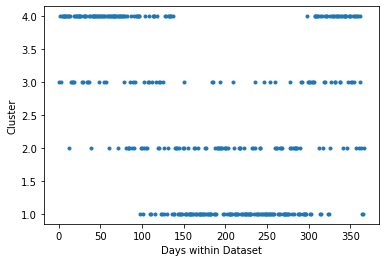

In [ ]:
## specify the number of clusters used to distribute Boston data
num_bos_clusters = 4

## identify the centroids for morning Boston datasaet, or the coordinats of the cluster centers
new_bos_centroids, _  = kmeans(new_scaled_bos_data, num_bos_clusters,iter=20)

## find an index that is the label for each value in morning Boston dataset
new_bos_idx, _ = vq(new_scaled_bos_data, new_bos_centroids)

## add 1 so that idx is also 1-based like morning_bos_df['season']
new_bos_idx=new_bos_idx+1

print('Print the cluster idx for each day of the year:') 
print(new_bos_idx) # prints K-mean's season label for each day in the year

day = np.arange(1,367,1)
plt.plot(day, new_bos_idx,'.')
plt.ylabel('Cluster')
plt.xlabel('Days within Dataset')

Print the cluster idx for each day of the year:
[3 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 4 3 3 3 3 4 3 3 3 3 3 3 3 3 2 3 2 4 4 4 4
 4 4 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 4 3 3 3 4 3 3 4 3 3 4 4 4 4 4 3 3 3 3 4
 3 3 3 3 3 3 4 3 4 3 3 4 4 2 4 3 2 3 4 1 2 3 3 3 4 4 3 4 2 3 2 3 3 2 4 4 3
 3 3 4 3 3 4 4 1 2 1 1 2 3 3 1 1 1 4 2 2 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 4 2 1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 2 1 1 2 1 2 2 1 2 1 2 2 2 1 1
 2 1 1 1 2 2 1 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 1 1 2 1 1 1 1 2 1 4 1 2 4 2
 1 1 1 2 1 1 1 4 1 1 2 1 2 1 1 2 1 1 4 1 1 4 3 2 3 3 2 1 3 3 3 3 4 3 3 3 4
 2 3 1 2 2 3 1 3 1 3 1 3 3 4 2 3 4 3 4 4 3 3 4 3 3 2 4 4 3 2 4 2 2 2 3 4 2
 2 4 3 4 3 4 3 4 4 3 3 4 4 4 3 4 4 4 4 4 3 4 3 3 4 3 4 4]


Text(0.5, 0, 'Days within Dataset')

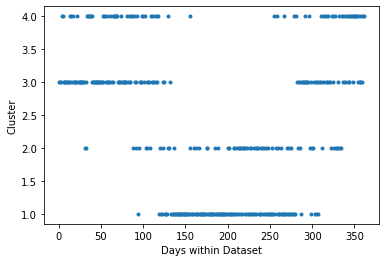

In [ ]:
## specify the number of clusters used to distribute Denver data
num_den_clusters = 4

## identify the centroids for morning Denver datasaet, or the coordinats of the cluster centers
new_den_centroids, _  = kmeans(new_scaled_den_data, num_den_clusters,iter=20)

## find an index that is the label for each value in morning Denver dataset
new_den_idx, _ = vq(new_scaled_den_data, new_den_centroids)

## add 1 so that idx is also 1-based like morning_den_df['season']
new_den_idx=new_den_idx+1

print('Print the cluster idx for each day of the year:') 
print(new_den_idx) # prints K-mean's season label for each day in the year

day = np.arange(1,362,1)
plt.plot(day, new_den_idx, '.')
plt.ylabel('Cluster')
plt.xlabel('Days within Dataset')

['drytemp_F', 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph', 'wgust_mph']
plotting these variables: ['drytemp_F', 'pres_mbar']
drytemp_F
pres_mbar


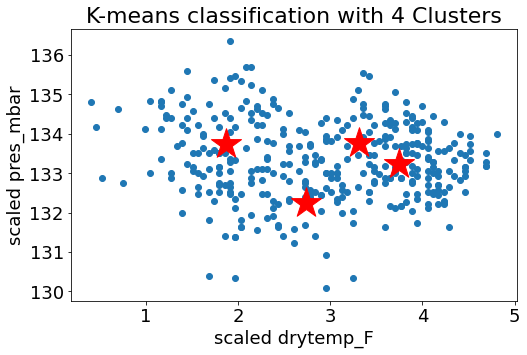

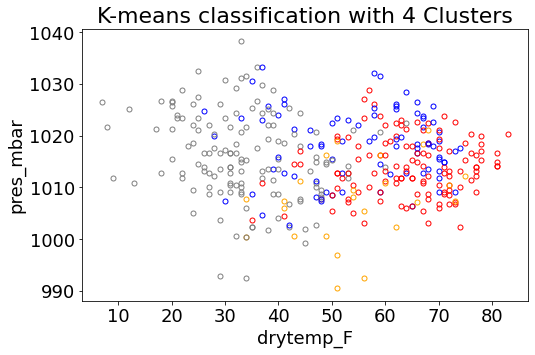

In [ ]:
## create a few xy scatter plots, where points are colored by "season" and each k-means-determined centroid is in a red stars overlaid.

## pick any two variables that are a part of included_cols
print(included_bos_cols)
## select two variables and put them in vars2plot - # format (x, y)
#plotted_bos_vars = ['drytemp_F','wgust_mph']

## other options for variables to plot
#plotted_bos_vars = ['RH','wspd_mph']
plotted_bos_vars = ['drytemp_F','pres_mbar']
#plotted_bos_vars = ['drytemp_F','wspd_mph']
#plotted_bos_vars = ['wspd_mph','wgust_mph']

print(f'plotting these variables: {plotted_bos_vars}')

plotted_bos_data = [new_morning_bos_data[:,included_bos_cols.index(var)] for var in plotted_bos_vars]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  print(plotted_bos_vars[i])
  varidx2plot[i]=included_bos_cols.index(plotted_bos_vars[i])

## plot these variables as scaled values with the cluster centers
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_bos_clusters) + ' Clusters',fontsize=22)
plt.scatter(new_scaled_bos_data[:, varidx2plot[0]], new_scaled_bos_data[:, varidx2plot[1]])
plt.scatter(new_bos_centroids[:, varidx2plot[0]], new_bos_centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('scaled '+plotted_bos_vars[0],fontsize=18);
plt.ylabel('scaled '+plotted_bos_vars[1],fontsize=18);
plt.show()

## plot these variables as the original values with colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_bos_clusters) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(plotted_bos_data)):
    plt.plot(val[0],val[1],".", color=cols[bos_idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(plotted_bos_vars[0],fontsize=18);
plt.ylabel(plotted_bos_vars[1],fontsize=18);

['drytemp_F', 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph', 'wgust_mph']
plotting these variables: ['drytemp_F', 'pres_mbar']
drytemp_F
pres_mbar


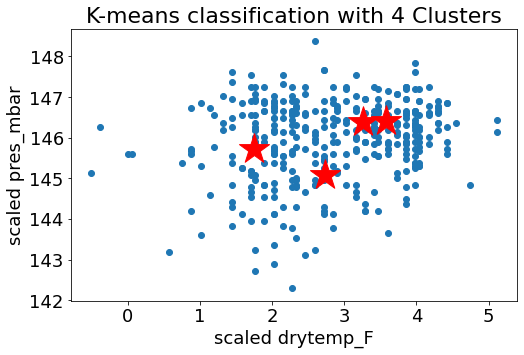

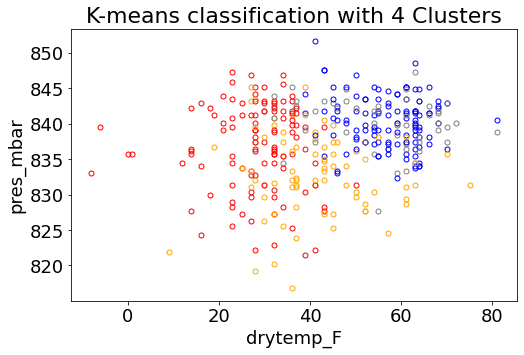

In [ ]:
## create a few xy scatter plots, where points are colored by "season" and each k-means-determined centroid is in a red stars overlaid.

## pick any two variables that are a part of included_cols
print(included_den_cols)
## select two variables and put them in vars2plot - # format (x, y)
#plotted_den_vars = ['drytemp_F','wgust_mph']

## other options for variables to plot
#plotted_den_vars = ['RH','wspd_mph']
plotted_den_vars = ['drytemp_F','pres_mbar']
#plotted_den_vars = ['drytemp_F','wspd_mph']
#plotted_den_vars = ['wspd_mph','wgust_mph']

print(f'plotting these variables: {plotted_den_vars}')

plotted_den_data = [new_morning_den_data[:,included_den_cols.index(var)] for var in plotted_den_vars]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  print(plotted_den_vars[i])
  varidx2plot[i]=included_den_cols.index(plotted_den_vars[i])

## plot these variables as scaled values with the cluster centers
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_den_clusters) + ' Clusters',fontsize=22)
plt.scatter(new_scaled_den_data[:, varidx2plot[0]], new_scaled_den_data[:, varidx2plot[1]])
plt.scatter(new_den_centroids[:, varidx2plot[0]], new_den_centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('scaled '+plotted_den_vars[0],fontsize=18);
plt.ylabel('scaled '+plotted_den_vars[1],fontsize=18);
plt.show()

## plot these variables as the original values with colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(num_den_clusters) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(plotted_den_data)):
    plt.plot(val[0],val[1],".", color=cols[den_idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(plotted_den_vars[0],fontsize=18);
plt.ylabel(plotted_den_vars[1],fontsize=18);

While these clusters don’t look as nice as the Boston 2012-2021 clusters due to less data being included, they are much easier to compare with each other. Visually, while there isn’t a hugely significant difference between the two cities, the Boston clusters look slightly more well separated, agreeing with our hypothesis and suggesting more seasonality.

###**Summary**

Initially, we planned to perform a statistical analysis of both datasets using both k-means clustering and bootstrapping techniques to calculate the centers of mass for each cluster. This would allow us to quantitatively determine which city produced better separated clusters. However, we were not able to implement the coding methods that would be able to do this due to inexperience with Python and time limitations. The Denver dataset presented difficulties in isolating times that were consistent throughout the file. Because of the errors that occurred throughout the filtering processes, we focused on only performing k-clustering for both datasets.

Upon applying the code to produce cluster plots, we noticed that most variables plotted for both the Denver and Boston datasets did not generate plots that exhibited definitive clusters; most 'clusters' were a part of the same mass of data with no clear definition between them. The only plot that produced relatively pronounced clusters was the dry bulb temperature plotted against the pressure for the Boston data from the years 2012 to 2021. Given the ambiguity of these clusters, we decided it could be useful to just isolate the year 2021 from each dataset and perform a similar clustering analysis to provide a better basis of comparison. Using the same variables, this method proved more viable, and we could even draw the conclusion that the Boston dataset produced clusters with a larger spread. This indicates that this location is slightly better characterized by four seasons when compared to the Denver location for the year 2021 and when analyzing temperature and pressure variables at approximately 6:00 AM. This conclusion is consistent with our hypothesis that the Boston data will produce more statistically distinct clusters than the Denver data given the use of four seasonal clusters.

**Our Hypothesis:**
We hypothesize that under four seasonal clusters, the Boston weather variables will produce more statistically distinct clusters than Denver.

**Did Our Analysis Support Our Hypothesis?** While visual interpretation of our clustering results supports our hypothesis, extensive additional analysis would need to be performed to make any definitive conclusions, with a focus on statistical analysis of the results.

# References

#####Barnes/Kay. “Lecture 6 (Machine Learning).” ATOC 4500, 03 March 2022, University of Colorado Boulder. Lecture.
#####Kay, J. (2022). Local Climatological Data (LCD) Boston Dataset 2012-2021. National Centers for Environmental Information. https://canvas.colorado.edu/courses/81910/files/45691684?module_item_id=3631483
#####Kay, J. (2022). Local Climatological Data (LCD) Denver Dataset 2002-2021. National Centers for Environmental Information. https://canvas.colorado.edu/courses/81910/files/45691691?module_item_id=3631484